In [1]:
!kaggle datasets download -d arjunbasandrai/medical-scan-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/arjunbasandrai/medical-scan-classification-dataset
License(s): other
100% 15.0G/15.0G [04:22<00:00, 71.5MB/s]
100% 15.0G/15.0G [04:22<00:00, 61.6MB/s]


In [2]:
!unzip ./medical-scan-classification-dataset.zip

Streaming output truncated to the last 5000 lines.
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1404.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1405.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1406.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1407.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1408.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1409.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem141.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1410.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1411.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1412.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1413.jpg  
  inflating: Alzheimer/Alzheimer/MRI/VeryMildDemented/verymildDem1414.jpg  
  inflating: Alzheimer/Alzheimer/MRI/V

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import ImageFolder
from torch.optim.lr_scheduler import LambdaLR
import torch.cuda.amp as amp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import numpy as np

# Parameters
imagesize = 256
batchsize = 32
rand_seed = 10
lr_init = 0.00015  # Initial learning rate
accumulation_steps = 4  # Gradient accumulation


In [4]:
# Data Augmentation and Normalization
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(0.2),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.RandomResizedCrop(imagesize, scale=(0.8, 1.0)),
    transforms.RandomAffine(degrees=0, scale=(0.8, 1.2)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

val_test_transform = transforms.Compose([
    transforms.Resize(imagesize),
    transforms.CenterCrop(imagesize),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])


In [5]:
# Load Dataset
dataset = ImageFolder('/content/Alzheimer/Alzheimer/MRI')

# Split Dataset into train, validation, and test sets (70%, 15%, 15%)
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset, [train_size, val_size, test_size], generator=torch.Generator().manual_seed(rand_seed))

# Apply Transforms
train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

train_loader = DataLoader(train_dataset, batch_size=batchsize, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batchsize, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batchsize, shuffle=False, num_workers=4, pin_memory=True)


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [6]:
# Load EfficientNetV2 model
base_model = models.efficientnet_v2_l(weights=models.EfficientNet_V2_L_Weights.IMAGENET1K_V1)

# Freeze all layers initially
for param in base_model.parameters():
    param.requires_grad = False

# Unfreeze layers after a certain point in the network
set_trainable = False
for name, layer in base_model.named_modules():
    if name == 'features.7.0.block.0.0':
        set_trainable = True
    if set_trainable:
        for param in layer.parameters():
            param.requires_grad = True

# Replace the classifier with identity (no-op)
base_model.classifier[1] = nn.Identity()

# Function to compute the input size for the first FC layer
def compute_flattened_size(model, input_size):
    with torch.no_grad():
        x = torch.randn(1, 3, input_size, input_size)
        x = model(x)
        return x.view(1, -1).size(1)

# Compute the input size for the first fully connected layer
fc_input_size = compute_flattened_size(base_model, imagesize)

# Define the custom model
class CustomModel(nn.Module):
    def __init__(self, base_model, fc_input_size):
        super(CustomModel, self).__init__()
        self.base_model = base_model
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(fc_input_size, 1024)
        self.ln1 = nn.LayerNorm(1024)
        self.fc2 = nn.Linear(1024, 512)
        self.ln2 = nn.LayerNorm(512)
        self.fc3 = nn.Linear(512, 4)  # 4 classes

    def forward(self, x):
        x = self.base_model(x)
        x = self.flatten(x)
        x = nn.ReLU()(self.ln1(self.fc1(x)))
        x = nn.ReLU()(self.ln2(self.fc2(x)))
        x = self.fc3(x)
        return x

model = CustomModel(base_model, fc_input_size)


Downloading: "https://download.pytorch.org/models/efficientnet_v2_l-59c71312.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_v2_l-59c71312.pth
100%|██████████| 455M/455M [00:06<00:00, 74.1MB/s]


In [7]:
# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr_init)
scaler = amp.GradScaler()  # For mixed precision training

# Learning Rate Scheduler
def lr_scheduler(epoch):
    if epoch < 8:
        return 1.0 + epoch * (lr_init / optimizer.param_groups[0]['lr'])
    elif epoch < 25:
        return 1.0  # Keep it constant
    else:
        return torch.exp(torch.tensor(-0.1 * (epoch - 25)))

scheduler = LambdaLR(optimizer, lr_lambda=lr_scheduler)


In [10]:
# Training Function with Validation
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs-1}')
        print('-' * 10)
        print(f'Current Learning Rate: {optimizer.param_groups[0]["lr"]:.6f}')

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
                loader = train_loader
            else:
                model.eval()   # Set model to evaluate mode
                loader = val_loader

            running_loss = 0.0
            running_corrects = 0
            optimizer.zero_grad()

            # Iterate over data with tqdm for progress bar
            for batch_idx, (inputs, labels) in enumerate(tqdm(loader, desc=f'{phase.capitalize()} Epoch {epoch}')):
                inputs = inputs.cuda()
                labels = labels.cuda()

                with torch.set_grad_enabled(phase == 'train'):
                    with amp.autocast():  # Mixed precision
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                    if phase == 'train':
                        scaler.scale(loss).backward()

                        # Perform optimizer step after accumulating gradients
                        if (batch_idx + 1) % accumulation_steps == 0:
                            scaler.step(optimizer)
                            scaler.update()
                            optimizer.zero_grad()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(loader.dataset)
            epoch_acc = running_corrects.double() / len(loader.dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

            if phase == 'train':
                train_acc_history.append(epoch_acc.cpu().numpy())
            else:
                val_acc_history.append(epoch_acc.cpu().numpy())

        print()

    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history


In [11]:
# Training the model
model = model.cuda()
model, train_acc, val_acc = train_model(model, criterion, optimizer, scheduler, num_epochs=17)



Epoch 0/16
----------
Current Learning Rate: 0.000150


Train Epoch 0: 100%|██████████| 771/771 [03:10<00:00,  4.05it/s]


Train Loss: 0.7169 Acc: 0.6706


Val Epoch 0: 100%|██████████| 165/165 [00:35<00:00,  4.61it/s]


Val Loss: 0.4645 Acc: 0.8032

Epoch 1/16
----------
Current Learning Rate: 0.000300


Train Epoch 1: 100%|██████████| 771/771 [03:16<00:00,  3.93it/s]


Train Loss: 0.4369 Acc: 0.8184


Val Epoch 1: 100%|██████████| 165/165 [00:34<00:00,  4.78it/s]


Val Loss: 0.2391 Acc: 0.9038

Epoch 2/16
----------
Current Learning Rate: 0.000300


Train Epoch 2: 100%|██████████| 771/771 [03:17<00:00,  3.91it/s]


Train Loss: 0.2378 Acc: 0.9085


Val Epoch 2: 100%|██████████| 165/165 [00:33<00:00,  4.90it/s]


Val Loss: 0.1570 Acc: 0.9445

Epoch 3/16
----------
Current Learning Rate: 0.000375


Train Epoch 3: 100%|██████████| 771/771 [03:19<00:00,  3.87it/s]


Train Loss: 0.1740 Acc: 0.9353


Val Epoch 3: 100%|██████████| 165/165 [00:34<00:00,  4.76it/s]


Val Loss: 0.1145 Acc: 0.9563

Epoch 4/16
----------
Current Learning Rate: 0.000390


Train Epoch 4: 100%|██████████| 771/771 [03:15<00:00,  3.94it/s]


Train Loss: 0.1224 Acc: 0.9559


Val Epoch 4: 100%|██████████| 165/165 [00:33<00:00,  4.93it/s]


Val Loss: 0.1312 Acc: 0.9553

Epoch 5/16
----------
Current Learning Rate: 0.000438


Train Epoch 5: 100%|██████████| 771/771 [03:16<00:00,  3.93it/s]


Train Loss: 0.1062 Acc: 0.9615


Val Epoch 5: 100%|██████████| 165/165 [00:34<00:00,  4.78it/s]


Val Loss: 0.1114 Acc: 0.9640

Epoch 6/16
----------
Current Learning Rate: 0.000458


Train Epoch 6: 100%|██████████| 771/771 [03:17<00:00,  3.90it/s]


Train Loss: 0.0915 Acc: 0.9679


Val Epoch 6: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


Val Loss: 0.1027 Acc: 0.9655

Epoch 7/16
----------
Current Learning Rate: 0.000494


Train Epoch 7: 100%|██████████| 771/771 [03:18<00:00,  3.88it/s]


Train Loss: 0.0814 Acc: 0.9716


Val Epoch 7: 100%|██████████| 165/165 [00:35<00:00,  4.68it/s]


Val Loss: 0.0994 Acc: 0.9674

Epoch 8/16
----------
Current Learning Rate: 0.000150


Train Epoch 8: 100%|██████████| 771/771 [03:18<00:00,  3.88it/s]


Train Loss: 0.0356 Acc: 0.9873


Val Epoch 8: 100%|██████████| 165/165 [00:34<00:00,  4.79it/s]


Val Loss: 0.0412 Acc: 0.9854

Epoch 9/16
----------
Current Learning Rate: 0.000150


Train Epoch 9: 100%|██████████| 771/771 [03:19<00:00,  3.87it/s]


Train Loss: 0.0170 Acc: 0.9947


Val Epoch 9: 100%|██████████| 165/165 [00:35<00:00,  4.70it/s]


Val Loss: 0.0391 Acc: 0.9881

Epoch 10/16
----------
Current Learning Rate: 0.000150


Train Epoch 10: 100%|██████████| 771/771 [03:19<00:00,  3.87it/s]


Train Loss: 0.0196 Acc: 0.9933


Val Epoch 10: 100%|██████████| 165/165 [00:33<00:00,  4.92it/s]


Val Loss: 0.0446 Acc: 0.9867

Epoch 11/16
----------
Current Learning Rate: 0.000150


Train Epoch 11: 100%|██████████| 771/771 [03:15<00:00,  3.94it/s]


Train Loss: 0.0162 Acc: 0.9944


Val Epoch 11: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


Val Loss: 0.0342 Acc: 0.9900

Epoch 12/16
----------
Current Learning Rate: 0.000150


Train Epoch 12: 100%|██████████| 771/771 [03:19<00:00,  3.87it/s]


Train Loss: 0.0164 Acc: 0.9941


Val Epoch 12: 100%|██████████| 165/165 [00:34<00:00,  4.81it/s]


Val Loss: 0.0476 Acc: 0.9843

Epoch 13/16
----------
Current Learning Rate: 0.000150


Train Epoch 13: 100%|██████████| 771/771 [03:17<00:00,  3.91it/s]


Train Loss: 0.0141 Acc: 0.9956


Val Epoch 13: 100%|██████████| 165/165 [00:33<00:00,  4.88it/s]


Val Loss: 0.0404 Acc: 0.9879

Epoch 14/16
----------
Current Learning Rate: 0.000150


Train Epoch 14: 100%|██████████| 771/771 [03:17<00:00,  3.91it/s]


Train Loss: 0.0128 Acc: 0.9957


Val Epoch 14: 100%|██████████| 165/165 [00:34<00:00,  4.85it/s]


Val Loss: 0.0336 Acc: 0.9902

Epoch 15/16
----------
Current Learning Rate: 0.000150


Train Epoch 15: 100%|██████████| 771/771 [03:19<00:00,  3.87it/s]


Train Loss: 0.0162 Acc: 0.9949


Val Epoch 15: 100%|██████████| 165/165 [00:34<00:00,  4.82it/s]


Val Loss: 0.0393 Acc: 0.9877

Epoch 16/16
----------
Current Learning Rate: 0.000150


Train Epoch 16: 100%|██████████| 771/771 [03:18<00:00,  3.89it/s]


Train Loss: 0.0160 Acc: 0.9946


Val Epoch 16: 100%|██████████| 165/165 [00:34<00:00,  4.80it/s]

Val Loss: 0.0314 Acc: 0.9917



In [12]:
# Plot History
def plot_history(train_acc, val_acc):
    epochs = range(1, len(train_acc) + 1)

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.show()


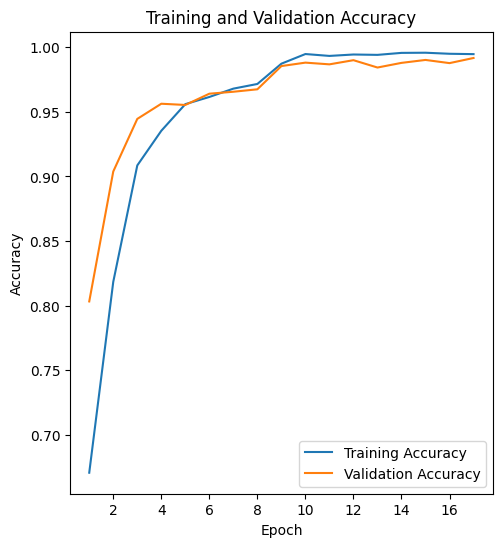

In [13]:
plot_history(train_acc, val_acc)

Evaluating on Test Set:   0%|          | 0/166 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Evaluating on Test Set: 100%|██████████| 166/166 [01:12<00:00,  2.30it/s]


Test Accuracy: 0.9919
Confusion Matrix:
[[ 686    0    4    1]
 [   0  992    0    0]
 [   1    0 1882   12]
 [   2    0   23 1678]]
Precision: 0.9919
Recall: 0.9919
F1 Score: 0.9919
Specificity: 0.9928
AUC: 0.9999


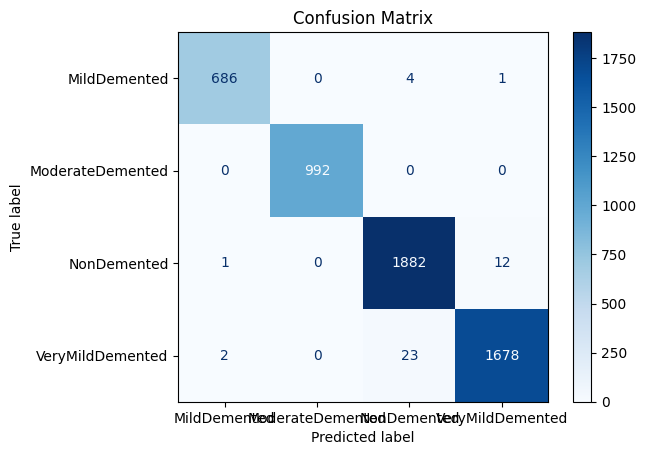

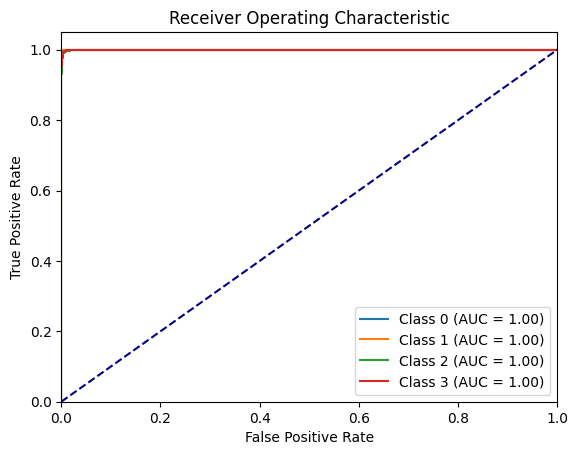

In [16]:
# Evaluate the model on the test set
def evaluate_model(model, test_loader):
    model.eval()
    running_corrects = 0
    all_labels = []
    all_preds = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc='Evaluating on Test Set'):
            inputs = inputs.cuda()
            labels = labels.cuda()
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            probs = torch.softmax(outputs, dim=1)
            running_corrects += torch.sum(preds == labels.data)

            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    test_acc = running_corrects.double() / len(test_loader.dataset)
    print(f'Test Accuracy: {test_acc.cpu().numpy():.4f}')

    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    print("Confusion Matrix:")
    print(cm)

    # Compute precision, recall, F1 score
    precision = precision_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    f1 = f1_score(all_labels, all_preds, average='weighted')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

    # Compute specificity
    tn = cm[0, 0]
    fp = cm[0, 1:].sum()
    specificity = tn / (tn + fp)
    print(f'Specificity: {specificity:.4f}')

    # Compute AUC
    try:
        auc = roc_auc_score(all_labels, np.array(all_probs), multi_class='ovr', average='weighted')
        print(f'AUC: {auc:.4f}')
    except ValueError:
        print("AUC cannot be calculated for this model and dataset.")

    # Plot confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=dataset.classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # Plot ROC curves
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(4):  # Assuming 4 classes
        fpr[i], tpr[i], _ = roc_curve(np.array(all_labels) == i, np.array(all_probs)[:, i])
        roc_auc[i] = roc_auc_score(np.array(all_labels) == i, np.array(all_probs)[:, i])

    plt.figure()
    for i in range(4):
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc='lower right')
    plt.show()

    return test_acc

# Evaluate the model on the test set and compute additional metrics
test_acc = evaluate_model(model, test_loader)